#  Instruction-Tuning with LLMs


Instruction-based fine-tuning, referred to as instruction GPT. It trains the language models to follow specific instructions and generate appropriate responses. For instruction-tuning, the dataset plays an important role as it provides structured examples of instructions, contexts, and responses, allowing the model to learn how to handle various tasks effectively. Instruction GPT often uses human feedback to refine and improve model performance; however, this lab doesn't cover this aspect.

The context and instruction are concatenated to form a single input sequence that the model can understand and use to generate the correct response.

#### Context and instruction

	•	Instruction: A command to specify what the model should do
	•	Context: Additional information or background required for performing the instruction
	•	Combined input: The instruction and context combine together into a single input sequence#  Instruction-Tuning with LLMs


Instruction-based fine-tuning, referred to as instruction GPT. It trains the language models to follow specific instructions and generate appropriate responses. For instruction-tuning, the dataset plays an important role as it provides structured examples of instructions, contexts, and responses, allowing the model to learn how to handle various tasks effectively. Instruction GPT often uses human feedback to refine and improve model performance; however, this lab doesn't cover this aspect.

The context and instruction are concatenated to form a single input sequence that the model can understand and use to generate the correct response.

#### Context and instruction

	•	Instruction: A command to specify what the model should do
	•	Context: Additional information or background required for performing the instruction
	•	Combined input: The instruction and context combine together into a single input sequence

Let's review certain examples for various templates:

Response template
Template: ### Question: {question}\n ### Answer: {answer}

Example:

### Question: What is the capital of France?
### Answer: Paris
Conversation template
Template: ### User: {user_input}\n ### Bot: {bot_response} Example:

### User: How are you today?
### Bot: I'm doing great, thank you! How can I assist you today?
Instruction and output template
Template: ### Instruction: {instruction}\n ### Output: {output}

Example:

### Instruction: Translate the following sentence to Spanish: "Hello, how are you?"
### Output: "Hola, ¿cómo estás?"
Completion template
Template: {prompt} ### Completion: {completion} Example:

Once upon a time in a faraway land, ### Completion: there lived a wise old owl who knew all the secrets of the forest.
Summarization template
Template: ### Text: {text}\n ### Summary: {summary}

Example:

### Text: The quick brown fox jumps over the lazy dog.
### Summary: A fox jumps over a dog.
Dialogue template
Template: ### Speaker 1: {utterance_1}\n ### Speaker 2: {utterance_2}\n ### Speaker 1: {utterance_3}

Example:

### Speaker 1: Hi, what are you doing today?
### Speaker 2: I'm going to the park.
### Speaker 1: That sounds fun!
Code generation template
Template: ### Task: {task_description}\n ### Code: {code_output}

Example:

### Task: Write a function to add two numbers in Python.
### Code: def add(a, b):\n    return a + b
Data analysis template
Template: ### Analysis Task: {task_description}\n ### Analysis: {analysis_output}

Example:

### Analysis Task: Provide insights from the sales data of Q1 2022.
### Analysis: The sales increased by 15% compared to Q4 2021, with the highest growth in the electronics category.
Recipe template
Template: ### Recipe Name: {recipe_name}\n ### Ingredients: {ingredients}\n ### Instructions: {instructions}

Example:

### Recipe Name: Chocolate Chip Cookies
### Ingredients: Flour, Sugar, Chocolate Chips, Butter, Eggs, Vanilla Extract
### Instructions: Mix the dry ingredients, add the wet ingredients, fold in the chocolate chips, and bake at 350°F for 10-12 minutes.
Explanation template
Template: ### Concept: {concept}\n ### Explanation: {explanation}

Example:

### Concept: Photosynthesis
### Explanation: Photosynthesis is the process by which green plants use sunlight to synthesize nutrients from carbon dioxide and water.

In [23]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from datasets import load_dataset
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
import evaluate
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM

from peft import get_peft_model, LoraConfig, TaskType

import pickle
import json
import matplotlib.pyplot as plt 

from urllib.request import urlopen
import io

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random_seed = 42

### Dataset: CodeAlpaca 20k
This is a programming code dataset. It contains three (or two) elements:
1. instruction: Describes the task the model should perform. Each of the 20K instructions is unique.
2. input: (optional) context for the task. For example, when the instruction is "Amend the following SQL query to select distinct elements", the input is the SQL query. Around 40% of the examples have an input.
3. output: the answer to the instruction as generated by text-davinci-003.

In [25]:
dataset = load_dataset("lucasmccabe-lmi/CodeAlpaca-20k", split="train") 
dataset = dataset.filter(lambda example: example["input"] == '') # Filter data without inputs
dataset = dataset.shuffle(seed=random_seed)
print(dataset)
print(dataset[100])

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 9764
})
{'instruction': 'Write all the possible combinations for the strings, "ABC" and "XYZ". Write corresponding code in Python.', 'input': '', 'output': 'ABCXYZ, ABCXZY, ABYXZC, ABYZXC, ACBXYZ, ACBXZY, ACYXZB, ACYZXB, AXBZYC, AXBYCZ, AXYBCZ, AXYZBC, XABCYZ, XABCZY, XAYBZC, XAYCZB, XBACYZ, XBACZY, XBYACZ, XBYZAC, XYABCZ, XYAZBC.'}


In [26]:
dataset_split = dataset.train_test_split(test_size=0.2, seed=random_seed)
train_dataset = dataset_split['train']
test_dataset = dataset_split['test']
print(test_dataset)

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 1953
})


In [27]:
model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path="facebook/opt-350m").to(device)
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m", padding_side='left')
print(tokenizer.eos_token)

</s>


In [28]:
def formatting_prompts(dataset):
    outputs = []
    for i in range(len(dataset['instruction'])):
        text = (
            f"### Instruction:\n{dataset['instruction'][i]}"
            f"\n\n### Response:\n{dataset['output'][i]}</s>"
        )
        outputs.append(text)
    return outputs

def formatting_promprts_without_response(dataset):
    outputs = []
    for i in range(len(dataset['instruction'])):
        text = (
            f"### Instruction:\n{dataset['instruction'][i]}"
            f"\n\n### Response:\n"
        )
        outputs.append(text)
    return outputs

In [29]:
expected_outputs = []
instruction_response_test = formatting_prompts(test_dataset)
instruction_test = formatting_promprts_without_response(test_dataset)

#for i in tqdm(range(len(instruction_response_test))):
for i in tqdm(range(48)): # For quick execution take 48 samples only
    tokenized_instruction_response_test = tokenizer(instruction_response_test[i], return_tensors="pt", max_length=1024, truncation=True, padding=False)
    tokenized_instruction_test = tokenizer(instruction_test[i], return_tensors="pt")
    expected_output = tokenizer.decode(tokenized_instruction_response_test['input_ids'][0][len(tokenized_instruction_test['input_ids'][0])-1:], skip_special_tokens=True)
    expected_outputs.append(expected_output)

100%|██████████| 48/48 [00:00<00:00, 6846.68it/s]


In [30]:
print('############## instructions ##############\n' + instruction_test[0])
print('############## instructions_with_responses ##############\n' + instruction_response_test[0])
print('\n############## expected_outputs ##############' + expected_outputs[0])

############## instructions ##############
### Instruction:
What type of data structure would you use to store key-value pairs in a Python program? Write corresponding code in Python.

### Response:

############## instructions_with_responses ##############
### Instruction:
What type of data structure would you use to store key-value pairs in a Python program? Write corresponding code in Python.

### Response:
The data structure to use for key-value pairs in Python is a dictionary. A dictionary is a data type that consists of key-value pairs, and is denoted by {} in Python. Each key has a unique value associated with it that can be accessed using the key. For example, a dictionary called "person" could look like this: 

person = {'name':'John', 'age': 32} 

The value of the key "name" can be accessed using person['name'] which returns "John".</s>

############## expected_outputs ##############
The data structure to use for key-value pairs in Python is a dictionary. A dictionary is a da

In [31]:
class FineTuningDataset(Dataset):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset 
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, index):
        return self.dataset[index]
    
instruction_test_torch = FineTuningDataset(instruction_test)
print(instruction_test_torch[0])

### Instruction:
What type of data structure would you use to store key-value pairs in a Python program? Write corresponding code in Python.

### Response:



Testing how the base model performs without fine-tuning..

In [32]:
# Can generate tokens if return_tensors=True is set
# To exclude the instructions and focus on the response only, return_full_text=False is set
generation_pipeline = pipeline(task="text-generation", model=model, tokenizer=tokenizer,
                               device=device, batch_size=8, max_length=1024, truncation=True,
                               padding=False, return_full_text=False)

Device set to use cuda


In [33]:
tokenizer.padding_side = 'left'

with torch.no_grad():
    pipeline_iterator = generation_pipeline(instruction_test_torch[:48], #First 48 samples
                                            max_length=1024, early_stopping=True)

generated_outputs_original = []
for text in pipeline_iterator:
    generated_outputs_original.append(text[0]["generated_text"])

In [34]:
# Visualize sample instructions, expected response from the dataset and response generated by the model
for i in range(3):
    print("#"*32)
    print("#### Instruction " + str(i+1) + ": ")
    print(instruction_test[i])
    print("\n\n")

    print("#### Expected Response " + str(i+1) + ": ")
    print(expected_outputs[i])
    print("\n\n")

    print("#### Generated Response From Original Model" + str(i+1) + ": ")
    print(generated_outputs_original[i])
    print("\n\n")

################################
#### Instruction 1: 
### Instruction:
What type of data structure would you use to store key-value pairs in a Python program? Write corresponding code in Python.

### Response:




#### Expected Response 1: 

The data structure to use for key-value pairs in Python is a dictionary. A dictionary is a data type that consists of key-value pairs, and is denoted by {} in Python. Each key has a unique value associated with it that can be accessed using the key. For example, a dictionary called "person" could look like this: 

person = {'name':'John', 'age': 32} 

The value of the key "name" can be accessed using person['name'] which returns "John".



#### Generated Response From Original Model1: 

I would like to know what type of data structure would you use to store key-value pairs in a Python program? Write corresponding code in Python.

### Instruction:
What type of data structure would you use to store key-value pairs in a Python program? Write correspon

Observations:
Responses extend and repeat answers until they generate the max number of tokens. Appending the EOS token to the output and then instruction fine-tune the model can fix this issue and generate better response.

Metric for evaluation: BLEU score which checks the quality of translation made by translation models. It can range from 0 to 1 or 0 to 100 depending on the implementaiton, with higher score meaning the two texts are similar i.e. its a good match.
A variation of the BLUE score is SacreBLEU that is independent of different parameters, unlike the original BLEU score

In [35]:
sacrebleu = evaluate.load("sacrebleu") # Need to install: pip install sacrebleu first
results_original = sacrebleu.compute(predictions=generated_outputs_original, references=expected_outputs)

print(list(results_original.keys()))
print(results_original["score"])

['score', 'counts', 'totals', 'precisions', 'bp', 'sys_len', 'ref_len']
0.10767772298900607


The SacreBLEU score is 0.1 out 100, which means the output has almost no alignment with the expected response.
We can see it individually in the previous block- basically the model just repeats the question itself and does not provide any answer at all.

In [36]:
# Apply parameter-efficient fine-tuning 
lora_config = LoraConfig(
    r=32, # Dimension of the low-rank 
    lora_alpha=16, # Scaling factor of delta Weight 
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],
    task_type=TaskType.CAUSAL_LM 
)
model = get_peft_model(model, lora_config)

Turing fine-tuning, we only want to calculate the loss function for the tokens after the reponse template, i.e. after "#### Response:\n". We can mask the tokens before that using -100 manually. Or we can use the data collator class from trl.

In [37]:
response_template = "### Response:\n"
collator = DataCollatorForCompletionOnlyLM(response_template=response_template, tokenizer=tokenizer)

In [38]:
training_args = SFTConfig(
    output_dir="instruction_fine_tuning",
    num_train_epochs=8, #Increase epochs
    save_strategy="epoch",
    fp16=True, 
    logging_steps=256,
    per_device_train_batch_size=4,  
    per_device_eval_batch_size=4,  
    max_seq_length=1024,
    do_eval=True,
    warmup_ratio=0.1,  # learning rate warmup
    lr_scheduler_type="cosine",  # scheduler
    learning_rate=1e-4,
    report_to="none"
)

trainer = SFTTrainer(
    model, 
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    formatting_func=formatting_prompts,
    args=training_args,
    data_collator=collator
)

In [39]:
trainer.train()

  2%|▏         | 258/15624 [00:16<16:27, 15.56it/s]

{'loss': 2.0481, 'grad_norm': 0.8704966306686401, 'learning_rate': 1.63787587971849e-05, 'epoch': 0.13}


  3%|▎         | 514/15624 [00:33<16:02, 15.69it/s]

{'loss': 1.8114, 'grad_norm': 1.1184014081954956, 'learning_rate': 3.27575175943698e-05, 'epoch': 0.26}


  5%|▍         | 770/15624 [00:49<15:39, 15.81it/s]

{'loss': 1.781, 'grad_norm': 1.4399017095565796, 'learning_rate': 4.91362763915547e-05, 'epoch': 0.39}


  7%|▋         | 1026/15624 [01:07<17:43, 13.73it/s]

{'loss': 1.757, 'grad_norm': 0.7817403674125671, 'learning_rate': 6.55150351887396e-05, 'epoch': 0.52}


  8%|▊         | 1282/15624 [01:24<15:36, 15.32it/s]

{'loss': 1.7014, 'grad_norm': 1.6501805782318115, 'learning_rate': 8.18937939859245e-05, 'epoch': 0.66}


 10%|▉         | 1538/15624 [01:42<15:22, 15.26it/s]

{'loss': 1.6993, 'grad_norm': 1.3227951526641846, 'learning_rate': 9.82725527831094e-05, 'epoch': 0.79}


 11%|█▏        | 1794/15624 [01:58<14:07, 16.32it/s]

{'loss': 1.6529, 'grad_norm': 1.4680498838424683, 'learning_rate': 9.993456899990032e-05, 'epoch': 0.92}


 13%|█▎        | 2050/15624 [02:15<14:51, 15.22it/s]

{'loss': 1.5621, 'grad_norm': 1.3528789281845093, 'learning_rate': 9.970673123689198e-05, 'epoch': 1.05}


 15%|█▍        | 2306/15624 [02:31<14:38, 15.16it/s]

{'loss': 1.6008, 'grad_norm': 2.699514150619507, 'learning_rate': 9.93181619422711e-05, 'epoch': 1.18}


 16%|█▋        | 2562/15624 [02:47<13:11, 16.49it/s]

{'loss': 1.6272, 'grad_norm': 2.1519999504089355, 'learning_rate': 9.876708520677302e-05, 'epoch': 1.31}


 18%|█▊        | 2818/15624 [03:04<13:55, 15.33it/s]

{'loss': 1.5054, 'grad_norm': 2.2814817428588867, 'learning_rate': 9.805651031932446e-05, 'epoch': 1.44}


 20%|█▉        | 3074/15624 [03:20<12:52, 16.25it/s]

{'loss': 1.5339, 'grad_norm': 1.2589868307113647, 'learning_rate': 9.719245321152941e-05, 'epoch': 1.57}


 21%|██▏       | 3330/15624 [03:37<13:28, 15.21it/s]

{'loss': 1.5263, 'grad_norm': 1.7085620164871216, 'learning_rate': 9.617096481421497e-05, 'epoch': 1.7}


 23%|██▎       | 3586/15624 [03:53<12:31, 16.02it/s]

{'loss': 1.4871, 'grad_norm': 3.086754322052002, 'learning_rate': 9.499846916415181e-05, 'epoch': 1.84}


 25%|██▍       | 3842/15624 [04:10<13:01, 15.08it/s]

{'loss': 1.4813, 'grad_norm': 0.9772626757621765, 'learning_rate': 9.367880103818916e-05, 'epoch': 1.97}


 26%|██▌       | 4098/15624 [04:27<11:52, 16.19it/s]

{'loss': 1.512, 'grad_norm': 1.1317273378372192, 'learning_rate': 9.221627655705445e-05, 'epoch': 2.1}


 28%|██▊       | 4354/15624 [04:43<12:19, 15.24it/s]

{'loss': 1.4843, 'grad_norm': 1.0866565704345703, 'learning_rate': 9.061567906900267e-05, 'epoch': 2.23}


 30%|██▉       | 4610/15624 [04:59<11:46, 15.59it/s]

{'loss': 1.4442, 'grad_norm': 1.0224113464355469, 'learning_rate': 8.888224350534617e-05, 'epoch': 2.36}


 31%|███       | 4866/15624 [05:16<11:23, 15.73it/s]

{'loss': 1.4344, 'grad_norm': 0.6979287266731262, 'learning_rate': 8.702163925903218e-05, 'epoch': 2.49}


 33%|███▎      | 5122/15624 [05:32<10:57, 15.97it/s]

{'loss': 1.459, 'grad_norm': 1.052979826927185, 'learning_rate': 8.504791991145048e-05, 'epoch': 2.62}


 34%|███▍      | 5378/15624 [05:49<10:48, 15.81it/s]

{'loss': 1.4208, 'grad_norm': 1.1904914379119873, 'learning_rate': 8.295206481551518e-05, 'epoch': 2.75}


 36%|███▌      | 5634/15624 [06:05<11:05, 15.02it/s]

{'loss': 1.386, 'grad_norm': 1.092282772064209, 'learning_rate': 8.074843634295213e-05, 'epoch': 2.88}


 38%|███▊      | 5890/15624 [06:22<11:08, 14.56it/s]

{'loss': 1.3862, 'grad_norm': 1.7411143779754639, 'learning_rate': 7.845342846290498e-05, 'epoch': 3.01}


 39%|███▉      | 6146/15624 [06:38<09:51, 16.03it/s]

{'loss': 1.3994, 'grad_norm': 1.2530680894851685, 'learning_rate': 7.605655211766107e-05, 'epoch': 3.15}


 41%|████      | 6402/15624 [06:55<09:19, 16.47it/s]

{'loss': 1.4131, 'grad_norm': 1.3404021263122559, 'learning_rate': 7.357445493357995e-05, 'epoch': 3.28}


 43%|████▎     | 6658/15624 [07:11<10:13, 14.61it/s]

{'loss': 1.3743, 'grad_norm': 1.1940377950668335, 'learning_rate': 7.101525488433468e-05, 'epoch': 3.41}


 44%|████▍     | 6914/15624 [07:28<09:21, 15.50it/s]

{'loss': 1.3371, 'grad_norm': 1.0967727899551392, 'learning_rate': 6.838732211705617e-05, 'epoch': 3.54}


 46%|████▌     | 7170/15624 [07:44<08:44, 16.12it/s]

{'loss': 1.3835, 'grad_norm': 1.5068553686141968, 'learning_rate': 6.569925157684017e-05, 'epoch': 3.67}


 48%|████▊     | 7426/15624 [08:00<08:34, 15.94it/s]

{'loss': 1.3734, 'grad_norm': 1.4280712604522705, 'learning_rate': 6.295983489602759e-05, 'epoch': 3.8}


 49%|████▉     | 7682/15624 [08:16<08:09, 16.24it/s]

{'loss': 1.3484, 'grad_norm': 1.4624055624008179, 'learning_rate': 6.018896878404677e-05, 'epoch': 3.93}


 51%|█████     | 7938/15624 [08:33<08:31, 15.03it/s]

{'loss': 1.3882, 'grad_norm': 2.2642078399658203, 'learning_rate': 5.7373989330322385e-05, 'epoch': 4.06}


 52%|█████▏    | 8194/15624 [08:49<07:48, 15.88it/s]

{'loss': 1.33, 'grad_norm': 1.2014834880828857, 'learning_rate': 5.4534892428001225e-05, 'epoch': 4.19}


 54%|█████▍    | 8450/15624 [09:06<07:35, 15.76it/s]

{'loss': 1.3338, 'grad_norm': 1.2200286388397217, 'learning_rate': 5.168096365786402e-05, 'epoch': 4.33}


 56%|█████▌    | 8706/15624 [09:23<07:15, 15.88it/s]

{'loss': 1.247, 'grad_norm': 0.9436575770378113, 'learning_rate': 4.882153710995749e-05, 'epoch': 4.46}


 57%|█████▋    | 8962/15624 [09:39<07:11, 15.44it/s]

{'loss': 1.355, 'grad_norm': 0.8784071207046509, 'learning_rate': 4.5965964855419246e-05, 'epoch': 4.59}


 59%|█████▉    | 9218/15624 [09:56<06:38, 16.06it/s]

{'loss': 1.3678, 'grad_norm': 1.5555012226104736, 'learning_rate': 4.3123586359493736e-05, 'epoch': 4.72}


 61%|██████    | 9474/15624 [10:12<06:22, 16.10it/s]

{'loss': 1.3762, 'grad_norm': 1.6519443988800049, 'learning_rate': 4.03036979357769e-05, 'epoch': 4.85}


 62%|██████▏   | 9730/15624 [10:28<06:10, 15.89it/s]

{'loss': 1.3008, 'grad_norm': 1.7893000841140747, 'learning_rate': 3.7515522341593355e-05, 'epoch': 4.98}


 64%|██████▍   | 9986/15624 [10:46<05:39, 16.60it/s]

{'loss': 1.3206, 'grad_norm': 1.8659096956253052, 'learning_rate': 3.476817861394723e-05, 'epoch': 5.11}


 66%|██████▌   | 10242/15624 [11:02<05:54, 15.20it/s]

{'loss': 1.2811, 'grad_norm': 1.6170631647109985, 'learning_rate': 3.207065224470207e-05, 'epoch': 5.24}


 67%|██████▋   | 10498/15624 [11:18<05:46, 14.80it/s]

{'loss': 1.2906, 'grad_norm': 1.4811190366744995, 'learning_rate': 2.9431765792534626e-05, 'epoch': 5.37}


 69%|██████▉   | 10754/15624 [11:35<05:07, 15.83it/s]

{'loss': 1.3321, 'grad_norm': 0.9831153750419617, 'learning_rate': 2.686015002777994e-05, 'epoch': 5.51}


 70%|███████   | 11010/15624 [11:51<04:46, 16.12it/s]

{'loss': 1.2808, 'grad_norm': 1.2531665563583374, 'learning_rate': 2.4373807557404437e-05, 'epoch': 5.64}


 72%|███████▏  | 11266/15624 [12:07<04:37, 15.72it/s]

{'loss': 1.2797, 'grad_norm': 1.2835369110107422, 'learning_rate': 2.196137485194409e-05, 'epoch': 5.77}


 74%|███████▎  | 11522/15624 [12:23<04:11, 16.34it/s]

{'loss': 1.2892, 'grad_norm': 1.6605138778686523, 'learning_rate': 1.9640645574633805e-05, 'epoch': 5.9}


 75%|███████▌  | 11778/15624 [12:41<04:10, 15.34it/s]

{'loss': 1.2823, 'grad_norm': 2.1407525539398193, 'learning_rate': 1.7419209927539965e-05, 'epoch': 6.03}


 77%|███████▋  | 12034/15624 [12:57<03:55, 15.24it/s]

{'loss': 1.2715, 'grad_norm': 2.5002427101135254, 'learning_rate': 1.5304333361916984e-05, 'epoch': 6.16}


 79%|███████▊  | 12290/15624 [13:13<03:45, 14.79it/s]

{'loss': 1.2702, 'grad_norm': 0.7449082732200623, 'learning_rate': 1.3302932815744423e-05, 'epoch': 6.29}


 80%|████████  | 12546/15624 [13:29<03:11, 16.08it/s]

{'loss': 1.2539, 'grad_norm': 2.2496755123138428, 'learning_rate': 1.1421554091115493e-05, 'epoch': 6.42}


 82%|████████▏ | 12802/15624 [13:46<02:54, 16.17it/s]

{'loss': 1.2561, 'grad_norm': 1.8914860486984253, 'learning_rate': 9.66635044546656e-06, 'epoch': 6.55}


 84%|████████▎ | 13058/15624 [14:02<02:43, 15.71it/s]

{'loss': 1.3064, 'grad_norm': 1.282939076423645, 'learning_rate': 8.043062466667295e-06, 'epoch': 6.69}


 85%|████████▌ | 13315/15624 [14:19<02:29, 15.48it/s]

{'loss': 1.2514, 'grad_norm': 1.9149730205535889, 'learning_rate': 6.556999297792482e-06, 'epoch': 6.82}


 87%|████████▋ | 13569/15624 [14:35<02:06, 16.27it/s]

{'loss': 1.2824, 'grad_norm': 1.3356081247329712, 'learning_rate': 5.213021272981649e-06, 'epoch': 6.95}


 88%|████████▊ | 13825/15624 [14:51<01:53, 15.90it/s]

{'loss': 1.2861, 'grad_norm': 1.050743579864502, 'learning_rate': 4.019911539047561e-06, 'epoch': 7.08}


 90%|█████████ | 14083/15624 [15:08<01:37, 15.88it/s]

{'loss': 1.2383, 'grad_norm': 1.6579736471176147, 'learning_rate': 2.972217131333549e-06, 'epoch': 7.21}


 92%|█████████▏| 14339/15624 [15:24<01:19, 16.15it/s]

{'loss': 1.2732, 'grad_norm': 2.138424873352051, 'learning_rate': 2.0783322946873297e-06, 'epoch': 7.34}


 93%|█████████▎| 14593/15624 [15:41<01:09, 14.93it/s]

{'loss': 1.2795, 'grad_norm': 1.6998246908187866, 'learning_rate': 1.3411805784434074e-06, 'epoch': 7.47}


 95%|█████████▌| 14851/15624 [15:57<00:49, 15.47it/s]

{'loss': 1.26, 'grad_norm': 1.6604410409927368, 'learning_rate': 7.631729189115811e-07, 'epoch': 7.6}


 97%|█████████▋| 15105/15624 [16:14<00:33, 15.55it/s]

{'loss': 1.2754, 'grad_norm': 1.468070387840271, 'learning_rate': 3.461997541427897e-07, 'epoch': 7.73}


 98%|█████████▊| 15363/15624 [16:30<00:16, 15.47it/s]

{'loss': 1.2288, 'grad_norm': 1.89386785030365, 'learning_rate': 9.162484104217051e-08, 'epoch': 7.86}


100%|█████████▉| 15619/15624 [16:46<00:00, 16.18it/s]

{'loss': 1.2715, 'grad_norm': 1.8502156734466553, 'learning_rate': 2.807950510608226e-10, 'epoch': 8.0}


100%|██████████| 15624/15624 [16:47<00:00, 15.50it/s]

{'train_runtime': 1007.8981, 'train_samples_per_second': 61.998, 'train_steps_per_second': 15.502, 'train_loss': 1.409563945551988, 'epoch': 8.0}


TrainOutput(global_step=15624, training_loss=1.409563945551988, metrics={'train_runtime': 1007.8981, 'train_samples_per_second': 61.998, 'train_steps_per_second': 15.502, 'total_flos': 2.507113729395917e+16, 'train_loss': 1.409563945551988, 'epoch': 8.0})

[2.0481, 1.8114, 1.781, 1.757, 1.7014, 1.6993, 1.6529, 1.5621, 1.6008, 1.6272, 1.5054, 1.5339, 1.5263, 1.4871, 1.4813, 1.512, 1.4843, 1.4442, 1.4344, 1.459, 1.4208, 1.386, 1.3862, 1.3994, 1.4131, 1.3743, 1.3371, 1.3835, 1.3734, 1.3484, 1.3882, 1.33, 1.3338, 1.247, 1.355, 1.3678, 1.3762, 1.3008, 1.3206, 1.2811, 1.2906, 1.3321, 1.2808, 1.2797, 1.2892, 1.2823, 1.2715, 1.2702, 1.2539, 1.2561, 1.3064, 1.2514, 1.2824, 1.2861, 1.2383, 1.2732, 1.2795, 1.26, 1.2754, 1.2288, 1.2715]


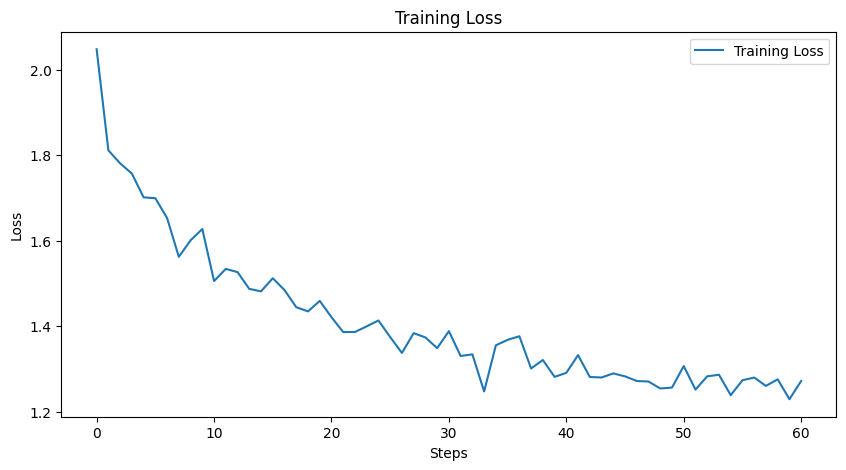

In [40]:
log_history_lora = trainer.state.log_history

train_loss = [log["loss"] for log in log_history_lora if "loss" in log]
print(train_loss)
# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [41]:
trainer.save_model("./instruction_fine_tuning")

Testing the newly trained model. Since the model is changed, we need to change the generation pipeline

In [42]:
generation_pipeline = pipeline(task="text-generation", model=model, tokenizer=tokenizer,
                               device=device, batch_size=8, max_length=1024, truncation=True,
                               padding=False, return_full_text=False)

Device set to use cuda
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaFo

In [43]:
with torch.no_grad():
    pipeline_iterator = generation_pipeline(instruction_test_torch[:48], #First 48 samples
                                            max_length=1024, early_stopping=True)

generated_outputs_finetuned = []
for text in pipeline_iterator:
    generated_outputs_finetuned.append(text[0]["generated_text"])

In [46]:
for i in range(3):
    print("#"*32)
    print("#### Instruction " + str(i+1) + ": ")
    print(instruction_test[i])
    print("\n\n")

    print("#### Expected Response " + str(i+1) + ": ")
    print(expected_outputs[i])
    print("\n\n")

    print("#### Generated Response From Fine-tuned Model" + str(i+1) + ": ")
    print(generated_outputs_finetuned[i])
    print("\n\n")

################################
#### Instruction 1: 
### Instruction:
What type of data structure would you use to store key-value pairs in a Python program? Write corresponding code in Python.

### Response:




#### Expected Response 1: 

The data structure to use for key-value pairs in Python is a dictionary. A dictionary is a data type that consists of key-value pairs, and is denoted by {} in Python. Each key has a unique value associated with it that can be accessed using the key. For example, a dictionary called "person" could look like this: 

person = {'name':'John', 'age': 32} 

The value of the key "name" can be accessed using person['name'] which returns "John".



#### Generated Response From Fine-tuned Model1: 
A data structure would be a type of data structure that stores key-value pairs in a Python program. This data structure can be used to store key-value pairs in a Python program by using a key-value pair type.



################################
#### Instruction 2: 

In [47]:
sacrebleu = evaluate.load("sacrebleu")
results_finetuned = sacrebleu.compute(predictions=generated_outputs_finetuned,
                                 references=expected_outputs)
print(list(results_finetuned.keys()))
print(results_finetuned["score"])

['score', 'counts', 'totals', 'precisions', 'bp', 'sys_len', 'ref_len']
7.194311961061762


After Fine-tuning for 8 epochs with low-rank of 32, the SacreBLEU score goes up from 0.1 to 7.19- a 71.9x improvement.